## 3.1 Transformations and adjustments

In [21]:
import pandas as pd
from plotnine import ggplot, geom_line, labs, aes, theme
import warnings
warnings.filterwarnings('ignore')

### Population adjustments

In [25]:
australia_economy = (
    pd.read_csv('../data/tsibbledata/global_economy.csv')
    .query("Country=='Australia'")
    .assign(GDP_per_pop=lambda df: df['GDP']/df['Population'])
)

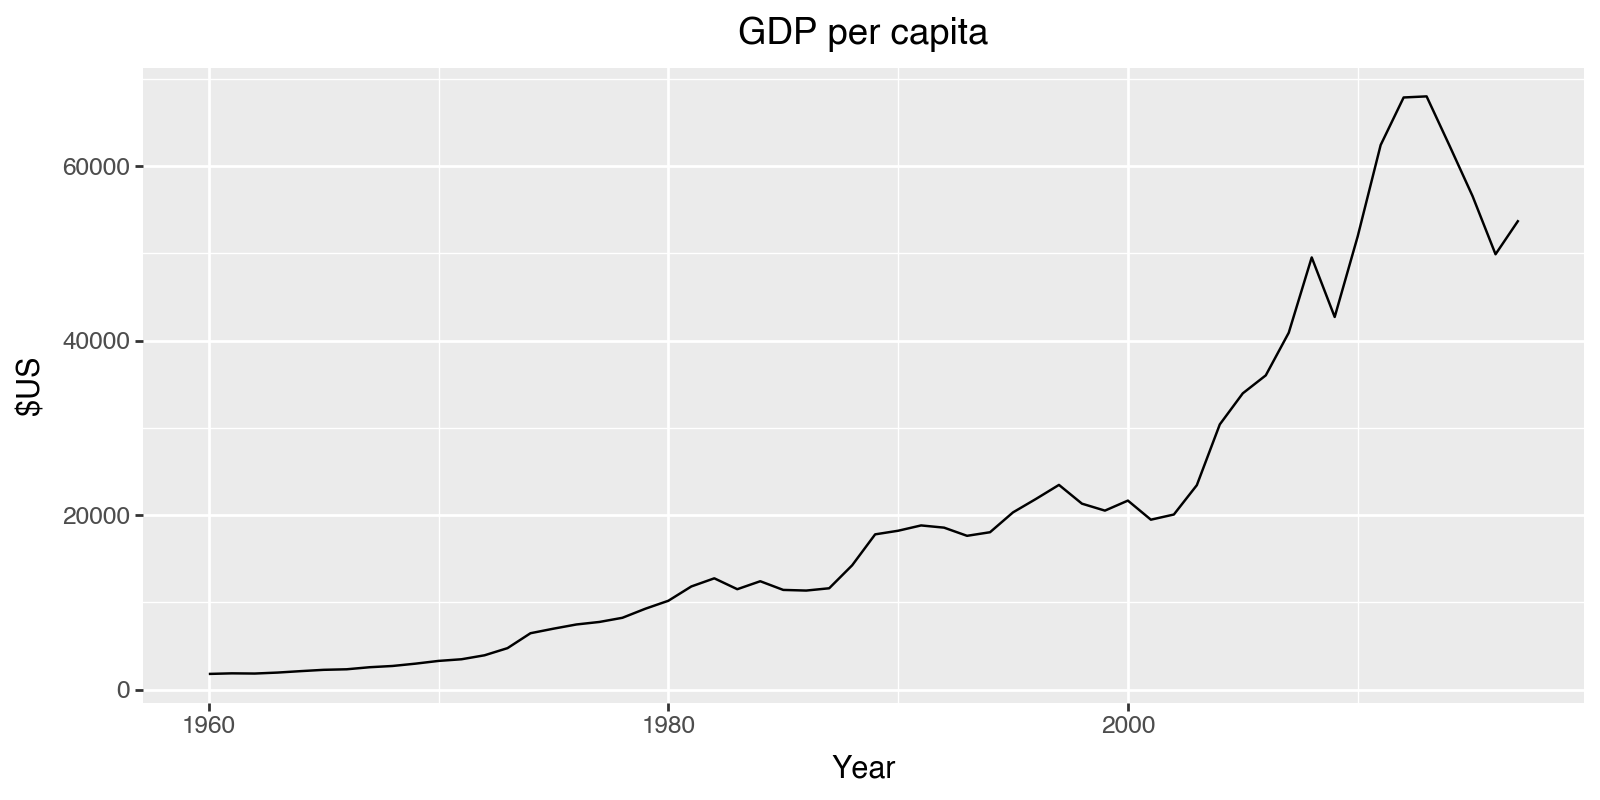

In [15]:
ggplot(australia_economy) \
    + aes(x='Year', y='GDP_per_pop') \
    + geom_line() \
    + labs(title= "GDP per capita", y = "$US") \
    + theme(figure_size=(8, 4))

### Inflation adjustments
Data which are affected by the value of money are best adjusted before modelling. For this reason, financial time series are usually adjusted so that all values are stated in dollar values from a particular year, e.g. the house price data may be stated in year 2012 dollars.

To make these adjustments, a price index is used. If $z_t$ denotes the price index and $y_t$ denotes the original house price in year $t$, then $x_t = y_t/z_t*z_{2012}$ gives the adjusted house price at year 2012 dollar values. Price indexes are often constructed by government agencies. For consumer goods, a common price index is the Consumer Price Index (or CPI).

In [24]:
print_retail = (
    pd.read_csv('../data/tsibbledata/aus_retail.csv', parse_dates=['Month'])
    .assign(Year = lambda df: df['Month'].dt.year)
    .query("Industry == 'Newspaper and book retailing'")
    .groupby(['Industry', 'Year'])
    .agg({'Turnover': 'sum'})
    .reset_index()
)

In [52]:
adjusted_print_retail = (print_retail
.merge(australia_economy, how='left', on='Year')
.assign(Adjusted_turnover=lambda df: df['Turnover'] / df['CPI']*100)
.set_index('Year')
)

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)

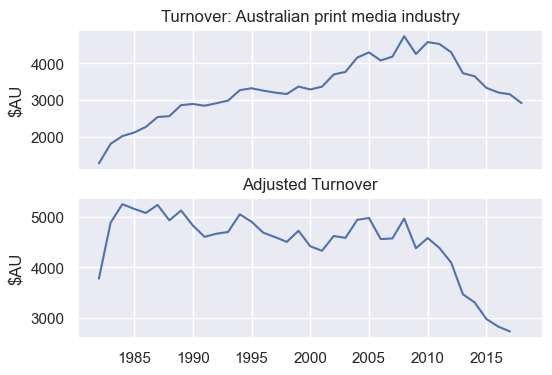

In [65]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 4))
axes[0].plot(adjusted_print_retail['Turnover'])
axes[0].set(title='Turnover: Australian print media industry', ylabel='$AU')
axes[1].plot(adjusted_print_retail.Adjusted_turnover)
axes[1].set(title='Adjusted Turnover', ylabel='$AU')
plt.show();

By adjusting for inflation using the CPI, we can see that Australia’s newspaper and book retailing industry has been in decline much longer than the original data suggests. The adjusted turnover is in 2010 Australian dollars, as CPI is 100 in 2010 in this data set.

### Mathematical transformations
#### Box-Cox Transformations
This is a _family_ of transformations, which includes both logarithmic and power transformation. These transformations depend on the parameter $\lambda$ and are defined as follows:
$$
w_t = \begin{cases} \log(y_t) & \text{if } \lambda = 0; \\ (\operatorname{sign}(y_t)|y_t|^\lambda - 1)/\lambda & \text{otherwise.} \end{cases}
$$
This is actually a modification of the original Box-Cox transformation, which allows for negative values of $y_t$ provided $\lambda > 0$. 

The logarithm in a Box-Cox transformation is always a **natural logarithm** (i.e. base $e$). So if $\lambda=0$, natural logarithms are used, but if $\lambda\ne 0$, a power transformation is used, followed by some simple scaling.
If $\lambda=1$, then $w_t=y_t-1$, so the transformed data is shifted downwards but there is no change in the shape of the time series. For all other values of $\lambda$, the time series will change shape.

In [ ]:
df = pd.read_csv('../data/tsibbledata/aus_production.csv')
aus_production = (
    df
    .assign(Date=pd.to_datetime(df['Quarter'].str.replace(' ', '')))
    .assign(Year=lambda df: df['Date'].dt.year)
    .set_index('Date')
    .drop(columns='Year'.split())
)


In [ ]:
from ipywidgets import interact
from scipy import stats

In [79]:
f = lambda lam: stats.boxcox(aus_production['Gas'], lam)

In [ ]:
@interact(lam=(-1, 2, .1))
def update(lam=1):
    fig, ax = plt.subplots()
    ax.plot(aus_production.index, stats.boxcox(aus_production.Gas, lam))
    ax.set_title(' ')
    fig.text(.01, .5, 'Transformed gas production', rotation=90,
             ha='left', va='center')
    fig.subplots_adjust(left=.1, right=.95, bottom=.1)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='lam', max=2.0, min=-1.0), Output()), _dom_classes=('…

#### Compute optimal Box-Cox transform parameter for input data
We make use of the `scipy.stats.boxcox_normmax` method, which gave an optimal $\lambda = 0.95$. See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox_normmax.html. Note this is different from the Guerreo method (Guerrero, 1993) used in the book, which gave an optimal $\lambda = 0.11$.

In [80]:
lambda_opt = stats.boxcox_normmax(aus_production['Gas'])

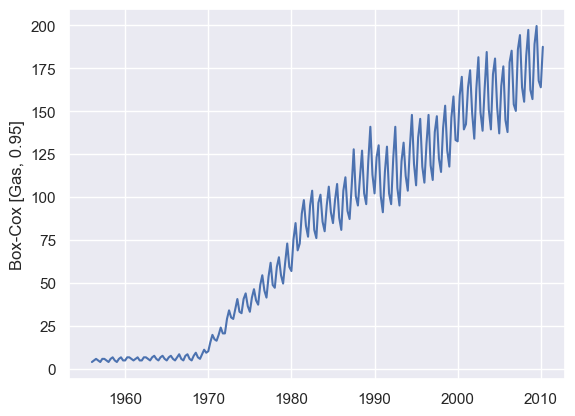

In [81]:
fig, ax = plt.subplots()
ax.plot(aus_production.index, stats.boxcox(aus_production['Gas'], lambda_opt))
ax.set(ylabel=f'Box-Cox [Gas, {lambda_opt:.2f}]')
plt.show();

#### References
- Box, G. E. P., & Cox, D. R. (1964). An analysis of transformations. Journal of the Royal Statistical Society. Series B, Statistical Methodology, 26(2), 211–252.
- Guerrero, V. M. (1993). Time-series analysis supported by power transformations. Journal of Forecasting, 12(1), 37–48.